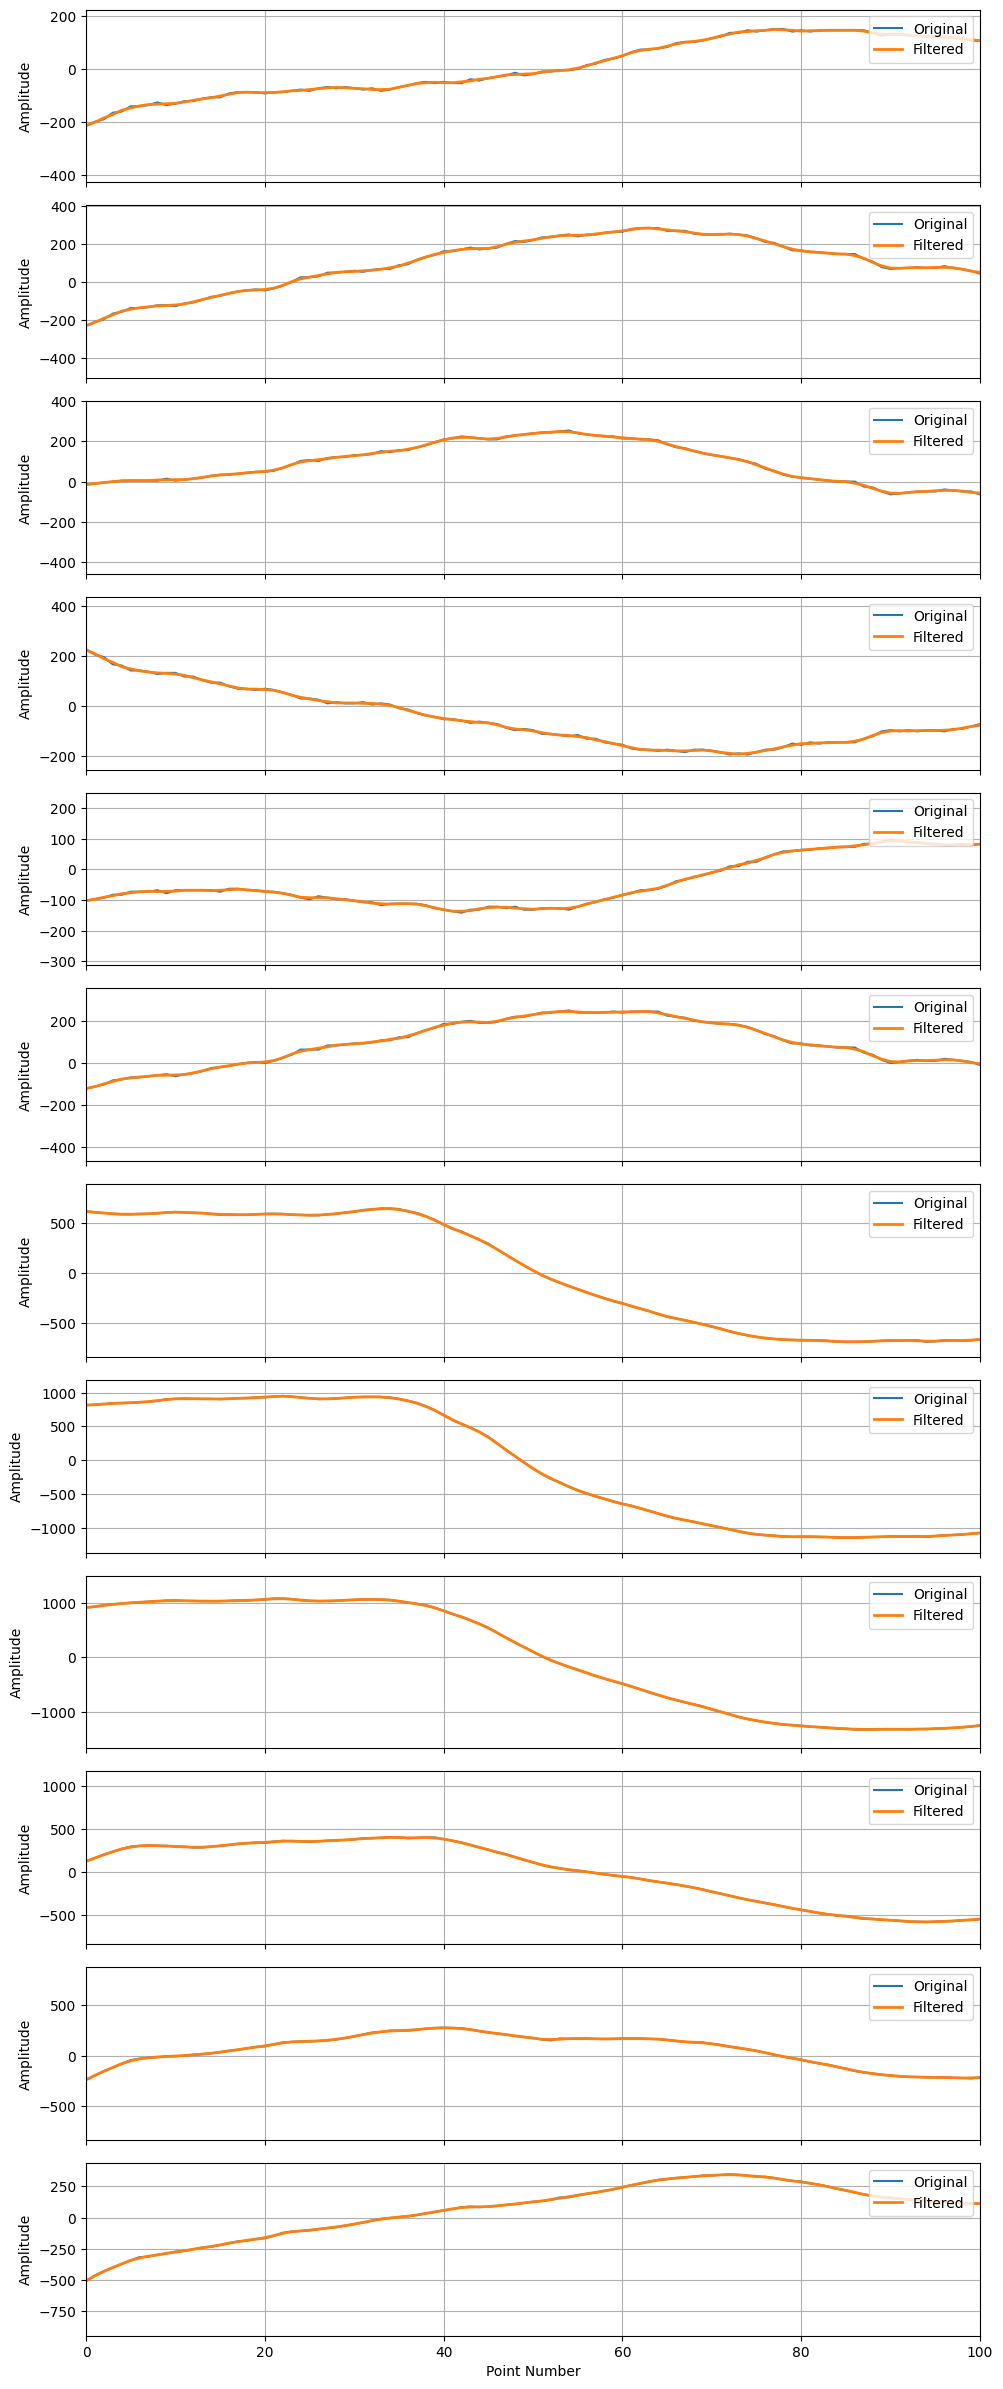

In [1]:
import matplotlib.pyplot as plt

def read_csv_multi(filename):
    """
    Reads a CSV file containing multiple signals.
    Each line should contain values for 12 channels separated by commas.
    Lines with headers or incorrect format are skipped.
    """
    channels = []
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split(',')
            try:
                values = [float(x) for x in parts]
            except ValueError:
                continue
            if not channels:
                channels = [[] for _ in range(len(values))]
            for i, v in enumerate(values):
                channels[i].append(v)
    return channels

def transpose_matrix(A):
    """
    Transposes the given matrix A (represented as a list of lists).
    """
    nrows = len(A)
    ncols = len(A[0])
    T = []
    for j in range(ncols):
        row = []
        for i in range(nrows):
            row.append(A[i][j])
        T.append(row)
    return T

def matrix_multiply(A, B):
    """
    Multiplies two matrices A and B.
    """
    nrows_A = len(A)
    ncols_A = len(A[0])
    ncols_B = len(B[0])
    result = []
    for i in range(nrows_A):
        row = []
        for j in range(ncols_B):
            s = 0.0
            for k in range(ncols_A):
                s += A[i][k] * B[k][j]
            row.append(s)
        result.append(row)
    return result

def matrix_inverse(M):
    """
    Calculates the inverse of matrix M using the Gauss-Jordan elimination method.
    """
    n = len(M)
    AM = []
    for i in range(n):
        row = []
        for j in range(n):
            row.append(M[i][j])
        for j in range(n):
            row.append(1.0 if i == j else 0.0)
        AM.append(row)
    
    for i in range(n):
        pivot = AM[i][i]
        if pivot == 0:
            for j in range(i+1, n):
                if AM[j][i] != 0:
                    AM[i], AM[j] = AM[j], AM[i]
                    pivot = AM[i][i]
                    break
            else:
                raise ValueError("The matrix is singular and cannot be inverted")
        for j in range(2*n):
            AM[i][j] /= pivot
        for k in range(n):
            if k == i:
                continue
            factor = AM[k][i]
            for j in range(2*n):
                AM[k][j] -= factor * AM[i][j]
    
    inv = []
    for i in range(n):
        inv.append(AM[i][n:2*n])
    return inv

def savgol_coeffs(window_size, poly_order):
    """
    Calculates the Savitzky-Golay filter coefficients.
    window_size: size of the window (must be odd)
    poly_order: order of the polynomial
    """
    m = (window_size - 1) // 2
    A = []
    for i in range(window_size):
        row = []
        x = i - m
        for k in range(poly_order + 1):
            row.append(x ** k)
        A.append(row)
    
    AT = transpose_matrix(A)
    ATA = matrix_multiply(AT, A)
    invATA = matrix_inverse(ATA)
    
    coeffs = []
    for j in range(window_size):
        x = j - m
        c = 0.0
        for k in range(poly_order + 1):
            c += invATA[0][k] * (x ** k)
        coeffs.append(c)
    return coeffs

def savgol_filter(signal, window_size, poly_order):
    """
    Applies the Savitzky-Golay filter to the input signal.
    """
    m = (window_size - 1) // 2
    coeffs = savgol_coeffs(window_size, poly_order)
    filtered = []
    N = len(signal)
    for i in range(N):
        if i < m or i >= N - m:
            filtered.append(signal[i])
        else:
            s = 0.0
            for j in range(window_size):
                s += coeffs[j] * signal[i - m + j]
            filtered.append(s)
    return filtered

if __name__ == '__main__':
    filename = 'ECGData/MUSE_20180111_155115_19000.csv'
    
    channels = read_csv_multi(filename)
    num_channels = len(channels)
    
    window_size = 3
    poly_order = 1
    
    fig, axs = plt.subplots(num_channels, 1, figsize=(10, 2*num_channels), sharex=True)
    
    for i, channel in enumerate(channels):
        filtered_channel = savgol_filter(channel, window_size, poly_order)
        x_values = list(range(len(channel)))
        axs[i].plot(x_values, channel, label='Original')
        axs[i].plot(x_values, filtered_channel, label='Filtered', linewidth=2)
        axs[i].set_ylabel('Amplitude')
        axs[i].legend(loc='upper right')
        axs[i].grid(True)
    
    axs[-1].set_xlabel('Point Number')
    plt.tight_layout()
    plt.xlim(0, 100)
    plt.show()
